Accessing and Working with database Cryptoccy

In [108]:
#database access
import psycopg2 as ps
import os
import pprint
#password setter
import getpass

#measuring runtime
from datetime import datetime
import time

#profiling
import pandas_profiling as pp


#for plotting
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
#matplotlib.use('pygtk')
import mpld3
#mpld3.enable_notebook()

#pandas
import pandas as pd
import pylab 
import sys
import scipy.stats as stats
#progress bar
from ipywidgets import FloatProgress
from IPython.display import display

#basic utility
import seaborn
import math
from pandas.plotting import autocorrelation_plot
import scipy.stats as stats


#hopefully speed things up
import numba
#prevent pandas errors
pd.options.mode.chained_assignment = None  # default='warn'



In [2]:
Password = getpass.getpass()


········


First Bunch of Helper Functions

In [3]:
def reconstruct_orderbook(currency_pair, exchange):
    
    #takes a currency_pair and exchange and returns a pandas dataframe containing all the orderbooks

    conn = ps.connect("dbname = 'Cryptoccy4' user = 'postgres' host='localhost' password = '{0}'".format(Password))
    cur = conn.cursor()
    cur.execute("SELECT * FROM orderbook WHERE orderbook.currency_pair_id='{0}' and \
        orderbook.exchange_id='{1}'".format(currency_pair,exchange) )
    
    orderbook = cur.fetchall()
    temp = ['orderbook_id', 'exchange_id', 'currency_pair_id', 'exchange_timestamp'
        , 'saved_timestamp', 'parent_orderbook_id', 'type']

    Data = {'orderbook_id':[], 'exchange_id':[], 'currency_pair_id':[], 'exchange_timestamp':[] \
            , 'saved_timestamp':[], 'parent_orderbook_id':[], 'type':[]}
    
    for i in range(0,len(orderbook)):
        for j in range(0,len(Data)):
            Data[temp[j]].append(orderbook[i][j])
        
    df = pd.DataFrame(data = Data)
    conn.close()
    
    orderbook_dataframe = df.sort_values(by = 'orderbook_id')
    
    
    return(orderbook_dataframe)



def get_full_orderbook_id(df, timestamp):
    #takes a df and a timestamp and returns the id of the last 
    #full orderbook before that point in time
    
    Id = []
    
    temp_df = df.loc[df['type']=='F']
    temp_df = temp_df.loc[temp_df['exchange_timestamp'] <= timestamp]
    Id.append(temp_df['orderbook_id'].tail(1).iloc[0])    
    
    return(Id[-1])



def get_all_orderbook_ids(df, timestamp, ret_l):
    #returns a df of all orderbooks that belong to the last full orderbook before the given timestamp
    #if ret_l = 1 returns a list with the Id's instead
    
    temp_df = df.loc[(df['exchange_timestamp'] <= timestamp) & (df['orderbook_id'] >= \
                     get_full_orderbook_id(df, timestamp))]
    if ret_l == 1:
        Id = []
        for i in range(0,len(temp_df)):
            Id.append(temp_df['orderbook_id'].iloc[i])
        return(Id)
    return(temp_df)

def reconstruct_orderbook_snapshots(Id):
    #fetches the orderbook given by the Id
    conn = ps.connect("dbname = 'Cryptoccy4' user = 'postgres' host='localhost' password = '{0}'".format(Password))
    cur = conn.cursor()
    cur.execute("SELECT * FROM limit_order WHERE limit_order.orderbook_id='{0}'".format(Id) )
    
    orderbook = cur.fetchall()
    temp = ['orderbook_id', 'order_id', 'limit_price', 'original_amount', 'status', 'order_type']
    limit_order_df = pd.DataFrame(data = orderbook, columns = temp)#columns dazu, pandas funktionsweise
    
    return(limit_order_df)
    
def sort_D_orderbooks(df):
    #sorts Delta orderbooks into two dataframes containing the Deletes and the New orders and returns those dfs
    df_temp_Del = df.loc[df['status'] == 'DEL']
    df_temp_New = df.loc[df['status'] == 'PNE']
    return(df_temp_Del, df_temp_New)


def build_from_ids(currency_pair, exchange, timestamp):
    #builds the actual orderbook at a given time and returns it as a df
    df = reconstruct_orderbook(currency_pair, exchange)
    Ids = get_all_orderbook_ids(df, timestamp,1)
    
    df_Full = reconstruct_orderbook_snapshots(Ids[0])
    df_Full.set_index('order_id', inplace = True)
    del Ids[0]
    for i in Ids:
        df_temp = reconstruct_orderbook_snapshots(i)
        df_del, df_new = sort_D_orderbooks(df_temp)
        df_new.set_index('order_id', inplace = True)
        
        df_del['order_id'] = df_del['order_id'] * (-1)
        
        #add new Transactions
        df_Full = pd.concat([df_Full, df_new])
        #delete old Transactions
        drop = df_del['order_id'].values.tolist()
        df_Full.drop(labels = drop, inplace = True)
    return (df_Full)


def get_VWAP(orderbook, amount, order_type):
    df = orderbook.loc[orderbook['order_type'] == order_type]
    
    if order_type == 'B':
        df.sort_values(by = ['limit_price'], ascending = False, inplace = True)
    elif order_type == 'A':
        df.sort_values(by = ['limit_price'], ascending = True, inplace = True)
    
    if df.empty == True:
        return(None)
    if df['original_amount'].head(1).iloc[0] >= amount:
        VWAP = df['limit_price'].head(1).iloc[0]
        return(VWAP)
    
    df['temp'] = df['original_amount'].cumsum()
    df['costs'] = df['original_amount'] * df['limit_price']
    df['cum_costs'] = df['costs'].cumsum()
    last_full_order_index = df.loc[df['temp'] < amount].tail(1).index[0]
    last_price = df.shift(-1).loc[last_full_order_index]['limit_price']
    if type(last_price) == float:
        VWAP = None
    else:
        VWAP = (last_price*(amount - df['temp'][last_full_order_index]) + df['cum_costs'][last_full_order_index])/amount
    return(VWAP)

    
def order_size_to_price_ratio(orderbook):
    orderbook['size_to_price'] = orderbook['limit_price']/orderbook['original_amount']
    
    avg_B = orderbook.loc[orderbook['order_type'] == 'B']['size_to_price'].mean()
    avg_A = orderbook.loc[orderbook['order_type'] == 'A']['size_to_price'].mean()
    
    return([avg_B, avg_A])


def get_statistics(orderbook):
    #helper that actually gets all the requested Data from a orderbook
    VWAP_20_bid = get_VWAP(orderbook, 20, 'B')
    VWAP_20_ask = get_VWAP(orderbook, 20, 'A')
    
    VWAP_10_bid = get_VWAP(orderbook, 10, 'B')
    VWAP_10_ask = get_VWAP(orderbook, 10, 'A')
   

    
    temp = order_size_to_price_ratio(orderbook)
    av_bid_volume_price_ratio = temp[0]
    av_ask_volume_price_ratio = temp[1]

    
    orderbook_bid = orderbook.loc[orderbook['order_type']=='B']
    Max_bid = orderbook_bid['limit_price'].max()
    Max_bid_volume = orderbook['original_amount'].loc[orderbook_bid['limit_price'].astype(float).idxmax()]
    bid_total_volume = orderbook_bid['original_amount'].sum()
    number_bids = orderbook_bid.shape[0]
    mean_bid_price = orderbook_bid['limit_price'].mean()
    mean_bid_volume = orderbook_bid['original_amount'].mean()
    
    
    orderbook_ask = orderbook.loc[orderbook['order_type']=='A']
    Min_ask = orderbook_ask['limit_price'].min()
    Min_ask_volume = orderbook_ask['original_amount'].loc[orderbook_ask['limit_price'].astype(float).idxmin()]
    ask_total_volume = orderbook_ask['original_amount'].sum()
    number_asks = orderbook_ask.shape[0]
    mean_ask_price = orderbook_ask['limit_price'].mean()
    mean_ask_volume = orderbook_ask['original_amount'].mean()

    Volumes = get_volume_imbalances(orderbook)
    (twenty_percent_volume_b, ten_percent_volume_b, five_percent_volume_b, twenty_percent_volume_a, \
    ten_percent_volume_a, five_percent_volume_a, top_twenty_volume_b, top_ten_volume_b, top_five_volume_b, \
    top_twenty_volume_a, top_ten_volume_a, top_five_volume_a, twenty_last_added_volume_b, \
    ten_last_added_volume_b, five_last_added_volume_b, twenty_last_added_volume_a, \
    ten_last_added_volume_a, five_last_added_volume_a, twenty_percent_mid_dev_volume_b, \
    ten_percent_mid_dev_volume_b, five_percent_mid_dev_volume_b, twenty_percent_mid_dev_volume_a, \
    ten_percent_mid_dev_volume_a, five_percent_mid_dev_volume_a) = Volumes
    
    return( [Max_bid, Max_bid_volume, mean_bid_price, mean_bid_volume, bid_total_volume, number_bids,\
             Min_ask, Min_ask_volume, mean_ask_price, mean_ask_volume, ask_total_volume, number_asks,\
              VWAP_20_bid, VWAP_20_ask, VWAP_10_bid, VWAP_10_ask, av_bid_volume_price_ratio, av_ask_volume_price_ratio,\
             twenty_percent_volume_b, ten_percent_volume_b, five_percent_volume_b, twenty_percent_volume_a, \
           ten_percent_volume_a, five_percent_volume_a, top_twenty_volume_b, top_ten_volume_b, top_five_volume_b, \
           top_twenty_volume_a, top_ten_volume_a, top_five_volume_a, twenty_last_added_volume_b, \
           ten_last_added_volume_b, five_last_added_volume_b, twenty_last_added_volume_a, \
           ten_last_added_volume_a, five_last_added_volume_a, twenty_percent_mid_dev_volume_b, \
           ten_percent_mid_dev_volume_b, five_percent_mid_dev_volume_b, twenty_percent_mid_dev_volume_a, \
           ten_percent_mid_dev_volume_a, five_percent_mid_dev_volume_a])




def fetch_max_bid_price_and_volume_for_id(Id):
    #first for the bids
    conn = ps.connect("dbname = 'Cryptoccy' user = 'postgres' host='localhost' password = '{0}'".format(Password))
    cur = conn.cursor()
    
    cur.execute("SELECT MAX(limit_price), SUM(original_amount), COUNT(order_id) FROM limit_order WHERE limit_order.orderbook_id='{0}'\
                and limit_order.order_type = 'B' and limit_order.status != 'DEL' ".format(Id) )
    max_volume_number = cur.fetchall()
    
    cur.execute("SELECT original_amount FROM limit_order WHERE limit_order.orderbook_id ='{0}' and limit_order.order_type = 'B' \
    and limit_order.status != 'DEL' and limit_order.limit_price = '{1}'".format(Id, max_volume_number[0][0]))
    best_bid_volume = cur.fetchall()
    
    #now for the asks
    cur.execute("SELECT MAX(limit_price), SUM(original_amount), COUNT(order_id) FROM limit_order WHERE limit_order.orderbook_id='{0}'\
                and limit_order.order_type = 'A' and limit_order.status != 'DEL' ".format(Id) )
    min_volume_number = cur.fetchall()
    
    cur.execute("SELECT original_amount FROM limit_order WHERE limit_order.orderbook_id ='{0}' and limit_order.order_type = 'A' \
    and limit_order.status != 'DEL' and limit_order.limit_price = '{1}'".format(Id, min_volume_number[0][0]))
    best_ask_volume = cur.fetchall()
    
    ret = list(max_volume_number[0]) + list(best_bid_volume[0]) + list(min_volume_number[0]) + list(best_ask_volume[0])
    return(ret)
        

Summarize Gamma and helpers -> summarize_gamma is the best summarize function at the moment

In [4]:
def get_volume_imbalances(orderbook):
    
    #vorerst weglassen
    #restricted percentage
    df_1 = restrict_orderbook(orderbook, amount=20, how=3)
    df_1_b = df_1.loc[df_1['order_type'] == 'B']
    df_1_a = df_1.loc[df_1['order_type'] == 'A']
    twenty_percent_volume_b = df_1_b['original_amount'].sum()
    twenty_percent_volume_a = df_1_a['original_amount'].sum()

    df_2 = restrict_orderbook(orderbook, amount=10, how=3)
    df_2_b = df_2.loc[df_2['order_type'] == 'B']
    df_2_a = df_2.loc[df_2['order_type'] == 'A']
    ten_percent_volume_b = df_2_b['original_amount'].sum()
    ten_percent_volume_a = df_2_a['original_amount'].sum()

    df_3 = restrict_orderbook(orderbook, amount=5, how=3)
    df_3_b = df_3.loc[df_3['order_type'] == 'B']
    df_3_a = df_3.loc[df_3['order_type'] == 'A']
    five_percent_volume_b = df_3_b['original_amount'].sum()
    five_percent_volume_a = df_3_a['original_amount'].sum()

    
    #top entries
    df_1 = restrict_orderbook(orderbook, amount=5, how=2)
    df_1_b = df_1.loc[df_1['order_type'] == 'B']
    df_1_a = df_1.loc[df_1['order_type'] == 'A']
    top_five_volume_b = df_1_b['original_amount'].sum()
    top_five_volume_a = df_1_a['original_amount'].sum()

    df_2 = restrict_orderbook(orderbook, amount=10, how=2)
    df_2_b = df_2.loc[df_2['order_type'] == 'B']
    df_2_a = df_2.loc[df_2['order_type'] == 'A']
    top_ten_volume_b = df_2_b['original_amount'].sum()
    top_ten_volume_a = df_2_a['original_amount'].sum()

    df_3 = restrict_orderbook(orderbook, amount=20, how=2)
    df_3_b = df_3.loc[df_3['order_type'] == 'B']
    df_3_a = df_3.loc[df_3['order_type'] == 'A']
    top_twenty_volume_b = df_3_b['original_amount'].sum()
    top_twenty_volume_a = df_3_a['original_amount'].sum()

    
    #last added entries
    df_1 = restrict_orderbook(orderbook, amount=20, how=5)
    df_1_b = df_1.loc[df_1['order_type'] == 'B']
    df_1_a = df_1.loc[df_1['order_type'] == 'A']
    twenty_last_added_volume_b = df_1_b['original_amount'].sum()
    twenty_last_added_volume_a = df_1_a['original_amount'].sum()

    df_2 = restrict_orderbook(orderbook, amount=10, how=5)
    df_2_b = df_2.loc[df_2['order_type'] == 'B']
    df_2_a = df_2.loc[df_2['order_type'] == 'A']
    ten_last_added_volume_b = df_2_b['original_amount'].sum()
    ten_last_added_volume_a = df_2_a['original_amount'].sum()

    df_3 = restrict_orderbook(orderbook, amount=5, how=5)
    df_3_b = df_3.loc[df_3['order_type'] == 'B']
    df_3_a = df_3.loc[df_3['order_type'] == 'A']
    five_last_added_volume_b = df_3_b['original_amount'].sum()
    five_last_added_volume_a = df_3_a['original_amount'].sum()
    
    
    #deviation from mid price
    df_1 = restrict_orderbook(orderbook, amount=20, how=4)
    df_1_b = df_1.loc[df_1['order_type'] == 'B']
    df_1_a = df_1.loc[df_1['order_type'] == 'A']
    twenty_percent_mid_dev_volume_b = df_1_b['original_amount'].sum()
    twenty_percent_mid_dev_volume_a = df_1_a['original_amount'].sum()

    df_2 = restrict_orderbook(orderbook, amount=10, how=4)
    df_2_b = df_2.loc[df_2['order_type'] == 'B']
    df_2_a = df_2.loc[df_2['order_type'] == 'A']
    ten_percent_mid_dev_volume_b = df_2_b['original_amount'].sum()
    ten_percent_mid_dev_volume_a = df_2_a['original_amount'].sum()

    df_3 = restrict_orderbook(orderbook, amount=5, how=4)
    df_3_b = df_3.loc[df_3['order_type'] == 'B']
    df_3_a = df_3.loc[df_3['order_type'] == 'A']
    five_percent_mid_dev_volume_b = df_3_b['original_amount'].sum()
    five_percent_mid_dev_volume_a = df_3_a['original_amount'].sum()

    
    return(    twenty_percent_volume_b, ten_percent_volume_b, five_percent_volume_a, twenty_percent_volume_a, \
           ten_percent_volume_a, five_percent_volume_a, top_twenty_volume_b, top_ten_volume_b, top_five_volume_b, \
           top_twenty_volume_a, top_ten_volume_a, top_five_volume_a, twenty_last_added_volume_b, \
           ten_last_added_volume_b, five_last_added_volume_b, twenty_last_added_volume_a, \
           ten_last_added_volume_a, five_last_added_volume_a, twenty_percent_mid_dev_volume_b, \
           ten_percent_mid_dev_volume_b, five_percent_mid_dev_volume_b, twenty_percent_mid_dev_volume_a, \
           ten_percent_mid_dev_volume_a, five_percent_mid_dev_volume_a   )

In [5]:
def summarize_order_books_gamma(currency_pair, exchange, n, restricted, amount):

    
    df_orderbook = reconstruct_orderbook(currency_pair, exchange)
    
    df_orderbook_F = df_orderbook.loc[df_orderbook['type']=='F']
    df_orderbook_F['next_index'] = df_orderbook_F.shift(1)['orderbook_id']
    df_orderbook_F['Id_tuple'] = df_orderbook_F[['orderbook_id', 'next_index']].apply(tuple, axis=1)
    df_orderbook_F['Id_list'] = df_orderbook_F['Id_tuple'].apply(( \
        lambda x: select_deltas_between_F_Ids(df_orderbook, x)))
    
    df_orderbook_F['Id_list'] = df_orderbook_F['Id_list'].shift(-1)
    df_orderbook_F['Timestamp_list'] = df_orderbook_F['Id_tuple'].apply(( \
        lambda x: build_timestamp_list(df_orderbook, x)))
    df_orderbook_F['Timestamp_list'] = df_orderbook_F['Timestamp_list'].shift(-1)
        
    category_list = ['Timestamp','Max_bid', 'Max_bid_volume', 'mean_bid_price', 'mean_bid_volume', 'bid_total_volume',\
                     'number_bids', 'Min_ask', 'Min_ask_volume', 'mean_ask_price', 'mean_ask_volume',\
                     'ask_total_volume', 'number_asks', 'VWAP_20_bid', 'VWAP_20_ask', 'VWAP_10_bid', 'VWAP_10_ask',\
                     'av_bid_volume_price_ratio', 'av_ask_volume_price_ratio', 'twenty_percent_volume_b',\
                     'ten_percent_volume_b', 'five_percent_volume_b', 'twenty_percent_volume_a', \
           'ten_percent_volume_a', 'five_percent_volume_a', 'top_twenty_volume_b', 'top_ten_volume_b', 'top_five_volume_b', \
           'top_twenty_volume_a', 'top_ten_volume_a', 'top_five_volume_a', 'twenty_last_added_volume_b', \
           'ten_last_added_volume_b', 'five_last_added_volume_b', 'twenty_last_added_volume_a', \
           'ten_last_added_volume_a', 'five_last_added_volume_a', 'twenty_percent_mid_dev_volume_b', \
           'ten_percent_mid_dev_volume_b', 'five_percent_mid_dev_volume_b', 'twenty_percent_mid_dev_volume_a', \
           'ten_percent_mid_dev_volume_a', 'five_percent_mid_dev_volume_a']
   
    if restricted is None or amount is None:
        restricted = 3
        amount = 100

    if n is None:
        n = df_orderbook_F['orderbook_id'].size

    elif n > df_orderbook_F['orderbook_id'].size:
        n = df_orderbook_F['orderbook_id'].size

    f = FloatProgress(min =0,  max = n)
    display(f)
    runs = 0
    for Id in df_orderbook_F['orderbook_id'][0:n]:
        df_loop  = reconstruct_orderbook_snapshots(Id)
        runs += 1
        if type(df_orderbook_F.loc[df_orderbook_F['orderbook_id'] == Id]['Id_list'].tolist()[0]) == list:
            if len(df_orderbook_F.loc[df_orderbook_F['orderbook_id'] == Id]['Id_list'].tolist()[0]) != 0:
                new_stats = go_multiple_steps(df_loop, df_orderbook_F.loc[df_orderbook_F['orderbook_id'] == Id]\
                            ['Id_list'], df_orderbook_F.loc[df_orderbook_F['orderbook_id'] == Id]['Timestamp_list'],\
                                             restricted, amount)
            else:
                loop_data_1 = get_statistics(df_loop)
                loop_data_2 = [df_orderbook_F.loc[df_orderbook_F['orderbook_id']==Id]['exchange_timestamp']] + loop_data_1
                new_stats = pd.DataFrame(columns = category_list)
                new_stats.loc[0] = loop_data_2
        else:
            loop_data_1 = get_statistics(df_loop)
            loop_data_2 = [df_orderbook_F.loc[df_orderbook_F['orderbook_id']==Id]['exchange_timestamp']] + loop_data_1
            new_stats = pd.DataFrame(columns = category_list)
            #return(new_stats, loop_data_2)
            new_stats.loc[0] = loop_data_2
        
        if runs == 1:
            df_stats = new_stats
        else:
            df_stats = pd.concat([df_stats, new_stats])
        f.value +=1
    df_stats['Mid'] = (df_stats['Min_ask'] + df_stats['Max_bid']) /2 
    df_stats['spread'] = (df_stats['Min_ask'] - df_stats['Max_bid'])/df_stats['Mid']
    df_stats['VWAP_n_bid'] = (df_stats['VWAP_20_bid']-df_stats['Mid'])/df_stats['Mid']
    df_stats['VWAP_n_ask'] = (df_stats['VWAP_20_ask']-df_stats['Mid'])/df_stats['Mid']
    df_stats['VWAP_n_spread'] = df_stats['VWAP_n_ask'] - df_stats['VWAP_n_bid']
    df_stats['log_returns'] = df_stats.shift(1)['Mid']/df_stats['Mid']
    #df_stats.dropna(inplace = True)
    df_stats['log_returns'] = df_stats['log_returns'].astype(float).apply(math.log)
    df_stats['Vola_last_10'] = df_stats['log_returns'].rolling(10).mean()

    df_stats.set_index('Timestamp', inplace = True)
    
    return(df_stats)

def select_deltas_between_F_Ids(df, ids):
    #returns the deltas between two Full orderbooks with ids id1 and id2 where id1 is the orderbook that occured first
    id1 = ids[1]
    id2 = ids[0]
    df = df.loc[(df['orderbook_id']>id1) & (df['orderbook_id']<id2)]
    Id_list = df['orderbook_id'].values.tolist()
    return(Id_list)

def build_timestamp_list(df, ids):
    #returns the deltas between two Full orderbooks with ids id1 and id2 where id1 is the orderbook that occured first
    id1 = ids[1]
    id2 = ids[0]
    df = df.loc[(df['orderbook_id']>id1) & (df['orderbook_id']<id2)]
    timestamps = df['exchange_timestamp'].tolist()
    return(timestamps)


def go_multiple_steps(df_loop, Id_chunks, timestamps, restricted, amount):
    
    conn = ps.connect("dbname = 'Cryptoccy4' user = 'postgres' host='localhost' password = '{0}'".format(Password))
    cur = conn.cursor()
    Id_chunks = Id_chunks.iloc[0]
    for_sql = tuple(Id_chunks)
    if len(Id_chunks) == 1:
        for_sql = '('+str(Id_chunks[0])+')'
    
    cur.execute("SELECT * FROM limit_order WHERE limit_order.orderbook_id IN {0}".format(for_sql))
    
    orderbook = cur.fetchall()
    temp = ['orderbook_id', 'order_id', 'limit_price', 'original_amount', 'status', 'order_type']

    category_list = ['Max_bid', 'Max_bid_volume', 'mean_bid_price', 'mean_bid_volume', 'bid_total_volume',\
                     'number_bids', 'Min_ask', 'Min_ask_volume', 'mean_ask_price', 'mean_ask_volume',\
                     'ask_total_volume', 'number_asks', 'VWAP_20_bid', 'VWAP_20_ask', 'VWAP_10_bid', 'VWAP_10_ask',\
                     'av_bid_volume_price_ratio', 'av_ask_volume_price_ratio', 'twenty_percent_volume_b',\
                     'ten_percent_volume_b', 'five_percent_volume_b', 'twenty_percent_volume_a', \
           'ten_percent_volume_a', 'five_percent_volume_a', 'top_twenty_volume_b', 'top_ten_volume_b', 'top_five_volume_b', \
           'top_twenty_volume_a', 'top_ten_volume_a', 'top_five_volume_a', 'twenty_last_added_volume_b', \
           'ten_last_added_volume_b', 'five_last_added_volume_b', 'twenty_last_added_volume_a', \
           'ten_last_added_volume_a', 'five_last_added_volume_a', 'twenty_percent_mid_dev_volume_b', \
           'ten_percent_mid_dev_volume_b', 'five_percent_mid_dev_volume_b', 'twenty_percent_mid_dev_volume_a', \
           'ten_percent_mid_dev_volume_a', 'five_percent_mid_dev_volume_a']
    
    Data =  {'Max_bid':[], 'Max_bid_volume':[], 'mean_bid_price':[], 'mean_bid_volume':[], 'bid_total_volume':[],\
                     'number_bids':[], 'Min_ask':[], 'Min_ask_volume':[], 'mean_ask_price':[], 'mean_ask_volume':[],\
                     'ask_total_volume':[], 'number_asks':[], 'VWAP_20_bid':[], 'VWAP_20_ask':[], 'VWAP_10_bid':[],\
             'VWAP_10_ask':[], 'av_bid_volume_price_ratio':[], 'av_ask_volume_price_ratio':[], \
             'twenty_percent_volume_b':[], 'ten_percent_volume_b':[], 'five_percent_volume_b':[],\
             'twenty_percent_volume_a':[], 'ten_percent_volume_a':[], 'five_percent_volume_a':[],\
             'top_twenty_volume_b':[], 'top_ten_volume_b':[], 'top_five_volume_b':[], 'top_twenty_volume_a':[],\
             'top_ten_volume_a':[], 'top_five_volume_a':[], 'twenty_last_added_volume_b':[], \
           'ten_last_added_volume_b':[], 'five_last_added_volume_b':[], 'twenty_last_added_volume_a':[], \
           'ten_last_added_volume_a':[], 'five_last_added_volume_a':[], 'twenty_percent_mid_dev_volume_b':[], \
           'ten_percent_mid_dev_volume_b':[], 'five_percent_mid_dev_volume_b':[], 'twenty_percent_mid_dev_volume_a':[], \
           'ten_percent_mid_dev_volume_a':[], 'five_percent_mid_dev_volume_a':[]}


    limit_order_df = pd.DataFrame(data = orderbook, columns = temp)
    df_stats = pd.DataFrame(data = Data)
    for count, Id in enumerate(Id_chunks):
        df_temp       = limit_order_df.loc[limit_order_df['orderbook_id']== Id]
        df_loop       = Apply_delta(df_loop, df_temp)
        
        if restricted == None:
            loop_data     = get_statistics(df_loop)
        else:
            loop_data = get_statistics(restrict_orderbook(df_loop, restricted, amount))
        df_stats_temp = pd.DataFrame(columns = category_list)
        df_stats_temp.loc[0] = loop_data
        df_stats      = pd.concat([df_stats, df_stats_temp])
    df_stats.insert(loc = 0, column = 'Timestamp', value = timestamps.tolist()[0])
    return(df_stats)

def Apply_delta(df,df2):
    # takes two orderbook, df2 being a Delta, and applying the changes in df2 to df, returning the new frame
    df_Last = df
    df_Delta = df2
    
    if df_Last.index.name != 'order_id':
        df_Last.set_index('order_id', inplace = True)
    
    df_del, df_new = sort_D_orderbooks(df_Delta)
    df_new.set_index('order_id', inplace = True)
    df_del['order_id'] = df_del['order_id'] * (-1)
    
    #add new Transactions
    df_Last = pd.concat([df_Last, df_new])
    
    #delete old Transactions
    drop = df_del['order_id'].values.tolist()
    df_Last.drop(labels = drop, inplace = True)
    df_Last.reset_index(inplace = True)
    return (df_Last)

def sort_D_orderbooks(df):
    #sorts Delta orderbooks into two dataframes containing the Deletes and the New orders and returns those dfs
    df_temp_Del = df.loc[df['status'] == 'DEL']
    df_temp_New = df.loc[df['status'] == 'PNE']
    return(df_temp_Del, df_temp_New)



Third Set of helpers (statistic helpers for orderbooks and summarizes dfs)

In [36]:
df = Results_restricted_percentage
df['log_returns'] = (df.shift(1)['Mid']/df['Mid'])
#df.dropna(inplace = True)
df['log_returns'] = df['log_returns'].astype(float).apply(math.log)
df['Vola_last_10'] = df['log_returns'].rolling(10).mean()
df

,Max_bid,Max_bid_volume,mean_bid_price,mean_bid_volume,bid_total_volume,number_bids,Min_ask,Min_ask_volume,mean_ask_price,mean_ask_volume,...,twenty_percent_mid_dev_volume_a,ten_percent_mid_dev_volume_a,five_percent_mid_dev_volume_a,Mid,spread,VWAP_n_bid,VWAP_n_ask,VWAP_n_spread,log_returns,Vola_last_10
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-06-28 16:04:01+02:00,6110.2000000000,0.7358621600,5345.894727,3.078297,10392.3292763800,3376,6110.3000000000,9.7162205400,7859.081520,2.549189,...,4955.7091228700,3848.0563545400,2832.6978990300,6110.2500000000,0.00001636594247371220490159977088,-0.0007802873946810686960435334070,0.0001063882985884374616423223272,0.0008866756932695061576858557342,NaN,NaN
2018-06-28 16:05:00+02:00,6110.2000000000,5.8437169900,5348.232357,3.076772,10402.5677501500,3381,6110.3000000000,6.2362549600,7857.905840,2.549440,...,4956.7519965700,3849.0992282400,2826.9407727300,6110.2500000000,0.00001636594247371220490159977088,-0.0004434395451495437993535452723,0.0002794200768135510003682337057,0.0007228596219630947997217789780,0.000000,NaN
2018-06-28 16:06:01+02:00,6110.2000000000,4.7431294900,5344.212930,3.086523,10407.7539463600,3372,6110.3000000000,8.2445834600,7860.233973,2.549343,...,4956.2772976600,3848.7142274500,2833.1666841900,6110.2500000000,0.00001636594247371220490159977088,-0.0005548223634221185712532220449,0.0001149240963954011701648868704,0.0006697464598175197414181089153,0.000000,NaN
2018-06-28 16:07:00+02:00,6110.2000000000,0.1030797500,5346.187507,3.078480,10399.1066443300,3378,6110.3000000000,6.7377882800,7859.107280,2.545483,...,4941.8124797900,3834.1597114600,2818.6131682000,6110.2500000000,0.00001636594247371220490159977088,-0.0008146247206742768299169428419,0.0002348066042224131582177488646,0.001049431324896689988134691706,0.000000,NaN
2018-06-28 16:08:04+02:00,6110.2000000000,0.6882797500,5347.609855,3.078271,10401.4788780900,3379,6110.3000000000,6.7278696200,7862.788187,2.549427,...,4955.5882337600,3848.0251635500,2832.4786202900,6110.2500000000,0.00001636594247371220490159977088,-0.0008235133446176506689578986130,0.0002222034015138496788183789534,0.001045716746131500347776277566,0.000000,NaN
2018-06-28 16:09:05+02:00,6109.9000000000,2.2618605700,5345.904501,3.079259,10398.6585405900,3377,6110.0000000000,5.6967506700,7857.519547,2.548391,...,4952.8163963600,3845.1483261500,2830.1008679500,6109.9500000000,0.00001636674604538498678385256835,-0.0006523252058445650128069787805,0.0002492205390387810047545397262,0.0009015457448833460175615185067,0.000049,NaN
2018-06-28 16:10:02+02:00,6109.7000000000,0.4106384800,5348.935294,3.073924,10399.0835684700,3383,6109.8000000000,6.3272312500,7856.479627,2.547040,...,4947.8422506500,3840.0844823200,2830.5429390600,6109.7500000000,0.00001636728180367445476492491509,-0.0006818441912844224395433528377,0.0003131707057326404517369777814,0.0009950148970170628912803306191,0.000033,NaN
2018-06-28 16:11:03+02:00,6111.0000000000,8.2770829400,5348.777883,3.073190,10393.5273314400,3382,6111.1000000000,12.3035895900,7857.722853,2.542969,...,4932.7510428300,3824.8299215000,2833.8513782400,6111.0500000000,0.00001636380000163638000016363800,-0.0003460890809762643080976264308,0.0001071940535996269053599626905,0.0004532831345758912134575891213,-0.000213,NaN
2018-06-28 16:11:59+02:00,6109.9000000000,2.0990503300,5346.837093,3.078199,10398.1573387900,3378,6110.0000000000,0.4156849600,7846.179680,2.541229,...,4927.7843108600,3820.0265425300,2815.4599992700,6109.9500000000,0.00001636674604538498678385256835,-0.0006556216269936742526534587026,0.0005018713703385461419487884516,0.001157492997332220394602247154,0.000180,NaN


In [6]:
def restrict_orderbook(orderbook, how, amount):
    #takes a orderbook without deletes and filters it after a condition of choice
    df_B = orderbook.loc[orderbook['order_type'] == 'B']
    df_A = orderbook.loc[orderbook['order_type'] == 'A']
    
    mid_price = (df_B['limit_price'].max() + df_A['limit_price'].min() )/2
    
    if how == 0:
        #restrict to amount Units - not working
        df_B.sort_values(by = ['limit_price'], ascending = False, inplace = True)
        df_A.sort_values(by = ['limit_price'], ascending = True, inplace = True)
        df_B['cumsum'] = df_B['original_amount'].cumsum()
        df_A['cumsum'] = df_A['original_amount'].cumsum()
        df_B = df_B.loc[df_B['cumsum'] <= amount]
        df_A = df_A.loc[df_A['cumsum'] <= amount]
        df = pd.concat([df_B, df_A])
    
    if how == 1:
        #restrict to amount Units try 2 - not working
        df_B.sort_values(by = ['limit_price'], ascending = False, inplace = True)
        df_A.sort_values(by = ['limit_price'], ascending = True, inplace = True)
        df_B['cumsum'] = df_B['original_amount'].cumsum()
        df_A['cumsum'] = df_A['original_amount'].cumsum()
        last_B = df_B.loc[df_B['cumsum'] > amount].head(1).index[0]
        ult_B = df_B.loc[last_B]
        last_A = df_A.loc[df_A['cumsum'] > amount].head(1).index[0]
        ult_A = df_A.loc[last_A]
        df_B = df_B.loc[df_B['cumsum'] <= amount]
        df_A = df_A.loc[df_A['cumsum'] <= amount]
        df_B.append(ult_B)
        df_A.append(ult_A)
        df = pd.concat([df_B, df_A])
        
        
    if how == 2:
        #restrict to top amount entries
        df_B.sort_values(by = ['limit_price'], ascending = False, inplace = True)
        df_A.sort_values(by = ['limit_price'], ascending = True, inplace= True)
        df_B = df_B[0:amount]
        df_A = df_A[0:amount]
        df = pd.concat([df_B, df_A])
    
    if how == 3:
        #restrict to top amount percent
        df_B.sort_values(by = ['limit_price'], ascending = False, inplace = True)
        df_A.sort_values(by = ['limit_price'], ascending = True, inplace= True)
        perc_B = int(df_B.shape[0]*amount/100)
        perc_A = int(df_A.shape[0]*amount/100)
        df_B = df_B[0:perc_B]
        df_A = df_A[0:perc_A]
        df = pd.concat([df_B, df_A])
    
    if how == 4:
        #percentege of deviation form the mid price
        mid = ( df_B['limit_price'].max() + df_A['limit_price'].min() )/2
        df_B = df_B.loc[df_B['limit_price'] >= int( mid* (100-amount)/100 ) ]
        df_A = df_A.loc[df_A['limit_price'] <= int( mid* (100+amount)/100 ) ]
        df = pd.concat([df_B, df_A])


    if how == 5:
        #last n entries that were added to the book
        if orderbook.index.name == 'order_id':
            df_B.reset_index(inplace = True)
            df_A.reset_index(inplace = True)
        df_B.sort_values(by = ['order_id'], ascending = True, inplace = True)
        df_A.sort_values(by = ['order_id'], ascending = True, inplace = True)
        df_B = df_B.tail(amount)
        df_A = df_A.tail(amount)
        df = pd.concat([df_B, df_A])
        if orderbook.index.name == 'order_id':
            df.set_index('order_id')

    return(df)


def encode(input_string):
    count = 1
    prev = ''
    lst = []
    for character in input_string:
        if character != prev:
            if prev:
                entry = (prev,count)
                lst.append(entry)
                #print lst
            count = 1
            prev = character
        else:
            count += 1
    else:
        try:
            entry = (character,count)
            lst.append(entry)
            return (lst, 0)
        except Exception as e:
            print("Exception encountered {e}".format(e=e)) 
            return (e, 1)
        
def temp_func(x, mn):
    if x > mn:
        return(1)
    else:
        return(0)

def check_for_randomness(df_org, keyword):
    df = df_org
    df['temp'] = df[keyword] - df.shift(1)[keyword]
    median = df['temp'].median()
    df['temp'] = df['temp'].apply(lambda x: temp_func(x, median))
    df['temp_2'] = df['temp'].apply(lambda x: 1+x)
    nr_runs = len(encode(df['temp_2'])[0])
    n = len(df)
    n_1 = df['temp'].sum()
    n_0 = n - n_1
    Mu = 1+((2*n_1*n_0)/n)
    sig = math.sqrt((Mu-1)*(Mu-2)/(n-1))
    #return(Mu, sig, n, n_1, n_0)
    if (nr_runs >= Mu-2*sig) & (nr_runs <= Mu+2*sig):
        return('Random')
    else:
        return('Not Random')
    
def colour_high_corr_values(val):
    color = 'red' if val < -0.75 or val > 0.75 else 'black'
    return 'color: %s' % color

def correlation_table(df_orig):
    df = df_orig.astype(float)
    A = {}
    df_temp = pd.DataFrame(columns = df.columns)
    for i in df.columns:
        A[i] = []
        for j in df.columns:
            A[i].append(df[i].corr(df[j]))
    df_ret = pd.DataFrame(columns = list(A.keys()), data = A)
    df_ret.set_index(df_ret.columns, inplace = True)
    df_ret = df_ret.style.applymap(colour_high_corr_values)
    return(df_ret)

def stats_of_summary(df):
    A = correlation_table(df)
    B = {}
    for i in df.columns:
        B[i] = check_for_randomness(df, i)
    return(A,B)


In [145]:
start = time.time()
#Restricted to 50 units of currency
Results_restricted_volume = summarize_order_books_gamma(1,9,10,1,50)
end = time.time()
print(end-start)

IndexError: single positional indexer is out-of-bounds

In [13]:
start = time.time()
#Restricted to 100 best bids and asks
Results_restricted_entries = summarize_order_books_gamma(1,9,30,2,1000)
end = time.time()
print(end-start)

FloatProgress(value=0.0, max=30.0)

963.6211888790131


In [7]:
start = time.time()
#restriced to top 75% 
Results_restricted_percentage = summarize_order_books_gamma(1,9,50,3,75 )
end = time.time()
print(end-start)

FloatProgress(value=0.0, max=50.0)

1291.3262586593628


In [10]:
df = Results_restricted_percentage
df['Mid']/df.shift(10)['Mid']

Timestamp
2018-06-28 15:50:01+02:00                               NaN
2018-06-28 15:51:02+02:00                               NaN
2018-06-28 15:52:01+02:00                               NaN
2018-06-28 15:53:03+02:00                               NaN
2018-06-28 15:53:59+02:00                               NaN
2018-06-28 15:55:00+02:00                               NaN
2018-06-28 15:56:04+02:00                               NaN
2018-06-28 15:56:58+02:00                               NaN
2018-06-28 15:57:59+02:00                               NaN
2018-06-28 15:59:01+02:00                               NaN
2018-06-28 16:00:02+02:00     1.001966810079901659496004917
2018-06-28 16:01:01+02:00     1.001950419995902479000204876
2018-06-28 16:02:00+02:00     1.001950419995902479000204876
2018-06-28 16:02:58+02:00     1.001475107559926244622003688
2018-06-28 16:04:01+02:00     1.001458693567816958541962025
2018-06-28 16:05:00+02:00     1.001458693567816958541962025
2018-06-28 16:06:01+02:00     

In [9]:
Results_restricted_percentage

,Max_bid,Max_bid_volume,mean_bid_price,mean_bid_volume,bid_total_volume,number_bids,Min_ask,Min_ask_volume,mean_ask_price,mean_ask_volume,...,ten_percent_mid_dev_volume_b,five_percent_mid_dev_volume_b,twenty_percent_mid_dev_volume_a,ten_percent_mid_dev_volume_a,five_percent_mid_dev_volume_a,Mid,spread,VWAP_n_bid,VWAP_n_ask,VWAP_n_spread
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-06-28 15:50:01+02:00,6101.2000000000,1.2446623900,5346.911772,3.078241,10407.5331418000,3381,6101.3000000000,3.7354941700,7843.938453,2.546987,...,4614.3789303900,2645.7400216400,4952.8763571600,3835.4634648200,2806.9777002200,6101.2500000000,0.00001639008399918049580004097521,-0.00007529278761729153861913542307,0.0005208219774226592911288670354,0.0005961147650399508297480024585
2018-06-28 15:51:02+02:00,6101.2000000000,1.1167411200,5346.861343,3.078643,10408.8913054700,3381,6101.3000000000,3.8300533400,7845.495333,2.549236,...,4615.6790940600,2647.0401853100,4961.2577236100,3843.8448312700,2815.3590666700,6101.2500000000,0.00001639008399918049580004097521,-0.00007134278267568121286621593936,0.0005282414663224749026838762549,0.0005995842489981561155500921943
2018-06-28 15:52:01+02:00,6101.2000000000,3.6659273000,5346.272795,3.079081,10401.1358220600,3378,6101.3000000000,1.9869157600,7844.178160,2.548645,...,4607.9236106500,2639.2847019000,4959.0948228400,3841.6819305000,2813.1961659000,6101.2500000000,0.00001639008399918049580004097521,-0.00006091382885474288055726285597,0.0006352055537717680803114115960,0.0006961193826265109608686744520
2018-06-28 15:53:03+02:00,6101.2000000000,6.4009844500,5347.291989,3.077414,10410.8908367200,3383,6101.3000000000,2.2727876900,7855.626933,2.549677,...,4617.7366253100,2649.0917165600,4957.1395210600,3839.7266287200,2811.1876641100,6101.2500000000,0.00001639008399918049580004097521,-0.0001623111850112681827494365909,0.0006615677440852284367957385782,0.0008238789290964966195451751691
2018-06-28 15:53:59+02:00,6101.3000000000,6.5285642500,5346.747914,3.021458,10209.5057660400,3379,6101.4000000000,1.9684185300,7860.589280,2.491485,...,4416.2935546300,2481.8306458800,4738.7026934400,3621.2898011000,2626.9328365000,6101.3500000000,0.00001638981536872987125800027863,-0.00009460417996836765633835134847,0.0009692065166725396838404615372,0.001063810696640907340178812886
2018-06-28 15:55:00+02:00,6101.3000000000,13.0951980500,5344.620681,3.022678,10201.5377266700,3375,6101.4000000000,1.9284185300,7863.133653,2.490635,...,4403.2895152600,2468.8266065100,4734.5110402500,3617.0981479100,2622.7411833100,6101.3500000000,0.00001638981536872987125800027863,-0.00002219879693838248912126004901,0.001080931764175141567030247404,0.001103130561113524056151507453
2018-06-28 15:56:04+02:00,6108.7000000000,6.5473700000,5348.494561,3.035029,10267.5045591600,3383,6108.8000000000,1.1865666100,7872.159413,2.527186,...,4457.3242060100,2462.9887458300,4822.0843507300,3714.4112805200,2725.7861740100,6108.7500000000,0.00001636996112134233681195007162,-0.0003198531307386944956005729486,0.0006356702475465520769388172703,0.0009555233782852465725393902189
2018-06-28 15:56:58+02:00,6108.7000000000,4.1675220300,5350.669303,3.016646,10220.3979226200,3388,6108.8000000000,3.3366560300,7869.820293,2.514067,...,4428.2565694700,2433.9211092900,4772.9302435700,3665.1674752400,2677.5423687300,6108.7500000000,0.00001636996112134233681195007162,-0.0004102373364518109269490484960,0.0005824655398649478207489257213,0.0009927028763167587476979742173
2018-06-28 15:57:59+02:00,6108.7000000000,3.3632411900,5350.359433,3.036532,10284.7327420100,3387,6108.8000000000,3.2446100200,7856.951227,2.519202,...,4493.1840733800,2498.8406132000,4843.4492896300,3735.7762194200,2748.6077639100,6108.7500000000,0.00001636996112134233681195007162,-0.0004379980306036423163494986699,0.0005137412384612236545938203397,0.0009517392690648659709433190096


In [11]:
start = time.time()
#restriced to up to 50% deviation from the mid price 
Results_restricted_deviation = summarize_order_books_gamma(1,9,50,4,100 )
end = time.time()
print(end-start)

406.03091764450073


In [12]:
start = time.time()
#restriced to the last 250 entries put into the book
Results_restricted_most_recent = summarize_order_books_gamma(1,9,50,5,250 )
end = time.time()
print(end-start)

218.43919610977173


In [8]:
Results_restricted_percentage

,Max_bid,Max_bid_volume,mean_bid_price,mean_bid_volume,bid_total_volume,number_bids,Min_ask,Min_ask_volume,mean_ask_price,mean_ask_volume,...,ten_percent_mid_dev_volume_b,five_percent_mid_dev_volume_b,twenty_percent_mid_dev_volume_a,ten_percent_mid_dev_volume_a,five_percent_mid_dev_volume_a,Mid,spread,VWAP_n_bid,VWAP_n_ask,VWAP_n_spread
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-06-28 15:50:01+02:00,6101.2000000000,1.2446623900,5346.911772,3.078241,10407.5331418000,3381,6101.3000000000,3.7354941700,7843.938453,2.546987,...,4614.3789303900,2645.7400216400,4952.8763571600,3835.4634648200,2806.9777002200,6101.2500000000,0.00001639008399918049580004097521,-0.00007529278761729153861913542307,0.0005208219774226592911288670354,0.0005961147650399508297480024585
2018-06-28 15:51:02+02:00,6101.2000000000,1.1167411200,5346.861343,3.078643,10408.8913054700,3381,6101.3000000000,3.8300533400,7845.495333,2.549236,...,4615.6790940600,2647.0401853100,4961.2577236100,3843.8448312700,2815.3590666700,6101.2500000000,0.00001639008399918049580004097521,-0.00007134278267568121286621593936,0.0005282414663224749026838762549,0.0005995842489981561155500921943
2018-06-28 15:52:01+02:00,6101.2000000000,3.6659273000,5346.272795,3.079081,10401.1358220600,3378,6101.3000000000,1.9869157600,7844.178160,2.548645,...,4607.9236106500,2639.2847019000,4959.0948228400,3841.6819305000,2813.1961659000,6101.2500000000,0.00001639008399918049580004097521,-0.00006091382885474288055726285597,0.0006352055537717680803114115960,0.0006961193826265109608686744520
2018-06-28 15:53:03+02:00,6101.2000000000,6.4009844500,5347.291989,3.077414,10410.8908367200,3383,6101.3000000000,2.2727876900,7855.626933,2.549677,...,4617.7366253100,2649.0917165600,4957.1395210600,3839.7266287200,2811.1876641100,6101.2500000000,0.00001639008399918049580004097521,-0.0001623111850112681827494365909,0.0006615677440852284367957385782,0.0008238789290964966195451751691
2018-06-28 15:53:59+02:00,6101.3000000000,6.5285642500,5346.747914,3.021458,10209.5057660400,3379,6101.4000000000,1.9684185300,7860.589280,2.491485,...,4416.2935546300,2481.8306458800,4738.7026934400,3621.2898011000,2626.9328365000,6101.3500000000,0.00001638981536872987125800027863,-0.00009460417996836765633835134847,0.0009692065166725396838404615372,0.001063810696640907340178812886
2018-06-28 15:55:00+02:00,6101.3000000000,13.0951980500,5344.620681,3.022678,10201.5377266700,3375,6101.4000000000,1.9284185300,7863.133653,2.490635,...,4403.2895152600,2468.8266065100,4734.5110402500,3617.0981479100,2622.7411833100,6101.3500000000,0.00001638981536872987125800027863,-0.00002219879693838248912126004901,0.001080931764175141567030247404,0.001103130561113524056151507453
2018-06-28 15:56:04+02:00,6108.7000000000,6.5473700000,5348.494561,3.035029,10267.5045591600,3383,6108.8000000000,1.1865666100,7872.159413,2.527186,...,4457.3242060100,2462.9887458300,4822.0843507300,3714.4112805200,2725.7861740100,6108.7500000000,0.00001636996112134233681195007162,-0.0003198531307386944956005729486,0.0006356702475465520769388172703,0.0009555233782852465725393902189
2018-06-28 15:56:58+02:00,6108.7000000000,4.1675220300,5350.669303,3.016646,10220.3979226200,3388,6108.8000000000,3.3366560300,7869.820293,2.514067,...,4428.2565694700,2433.9211092900,4772.9302435700,3665.1674752400,2677.5423687300,6108.7500000000,0.00001636996112134233681195007162,-0.0004102373364518109269490484960,0.0005824655398649478207489257213,0.0009927028763167587476979742173
2018-06-28 15:57:59+02:00,6108.7000000000,3.3632411900,5350.359433,3.036532,10284.7327420100,3387,6108.8000000000,3.2446100200,7856.951227,2.519202,...,4493.1840733800,2498.8406132000,4843.4492896300,3735.7762194200,2748.6077639100,6108.7500000000,0.00001636996112134233681195007162,-0.0004379980306036423163494986699,0.0005137412384612236545938203397,0.0009517392690648659709433190096


In [34]:
df = Results_restricted_deviation
df = df.astype(float)
pp.ProfileReport(df)

Number of variables,21
Number of observations,5783
Total Missing (%),0.0%
Total size in memory,948.9 KiB
Average record size in memory,168.0 B
Numeric,13
Categorical,0
Date,0
Text (Unique),1
Rejected,7
Distinct count,1957


In [ ]:
start = time.time()
Results = summarize_order_books_gamma(1,9,None, None, None)
end = time.time()
print(end-start)

In [23]:
Big_data = pd.read_hdf('C:/Users/janpa/Desktop/Uni/Bachelorarbeit/gathered_stats/BTC_USD_all_dbs_BitFinex.h5')

In [58]:
Results_restricted_deviation.to_hdf('C:/Users/janpa/Desktop/Uni/Bachelorarbeit/gathered_stats/temp.h5', \
               key = 'temp', mode = 'w')

C:\Users\janpa\Anaconda3\lib\site-packages\pandas\core\generic.py:1299: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->['Max_bid', 'Max_bid_volume', 'Min_ask', 'Min_ask_volume', 'VWAP_20_ask', 'VWAP_20_bid', 'ask_total_volume', 'bid_total_volume', 'number_asks', 'number_bids', 'Mid', 'spread', 'VWAP_n_bid', 'VWAP_n_ask']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [57]:
Results_restricted_most_recent.index[1].to_datetime().time().second

C:\Users\janpa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2881: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  exec(code_obj, self.user_global_ns, self.user_ns)


2

In [37]:
correlation_table(Results_restricted_deviation)

,Max_bid,Max_bid_volume,Min_ask,Min_ask_volume,VWAP_20_ask,VWAP_20_bid,ask_total_volume,av_ask_volume_price_ratio,av_bid_volume_price_ratio,bid_total_volume,mean_ask_price,mean_ask_volume,mean_bid_price,mean_bid_volume,number_asks,number_bids,Mid,spread,VWAP_n_bid,VWAP_n_ask
Max_bid,1,-0.0323709,0.999998,-0.0148306,0.999958,0.999966,-0.0588529,0.00718022,-0.091004,-0.596383,0.974825,0.62046,0.874746,-0.638755,-0.571258,0.837746,0.999999,-0.0238443,-0.0323074,0.102813
Max_bid_volume,-0.0323709,1,-0.03246,0.0508396,-0.0319999,-0.0291997,-0.00935805,-0.00380137,0.00514476,0.0832788,-0.0225354,0.0107011,-0.0561644,0.0808571,-0.0115539,-0.0466253,-0.0324155,-0.0381681,0.387914,0.0454819
Min_ask,0.999998,-0.03246,1,-0.0149697,0.999961,0.999963,-0.0589513,0.0071759,-0.091021,-0.596368,0.974844,0.620442,0.87472,-0.638736,-0.571299,0.837703,0.999999,-0.021622,-0.0326627,0.103235
Min_ask_volume,-0.0148306,0.0508396,-0.0149697,1,-0.0183044,-0.0153448,0.0695917,0.00681847,-0.00272852,0.046557,-0.00648163,0.0604266,-0.0144168,0.0468663,-0.00673109,-0.0406804,-0.0149001,-0.0613855,-0.0542704,-0.381424
VWAP_20_ask,0.999958,-0.0319999,0.999961,-0.0183044,1,0.99994,-0.0602891,0.00716625,-0.0908943,-0.596641,0.974871,0.620014,0.874613,-0.639015,-0.571801,0.837996,0.99996,-0.0210679,-0.0307555,0.111885
VWAP_20_bid,0.999966,-0.0291997,0.999963,-0.0153448,0.99994,1,-0.0582872,0.00694374,-0.0911158,-0.595542,0.974761,0.620632,0.874431,-0.637953,-0.571027,0.837386,0.999965,-0.0240371,-0.024181,0.104631
ask_total_volume,-0.0588529,-0.00935805,-0.0589513,0.0695917,-0.0602891,-0.0582872,1,0.00098443,0.00224928,-0.0152977,-0.153608,0.11949,0.00912537,-0.00127673,0.522304,-0.110204,-0.0589021,-0.041253,0.0728848,-0.160021
av_ask_volume_price_ratio,0.00718022,-0.00380137,0.0071759,0.00681847,0.00716625,0.00694374,0.00098443,1,-0.00379631,0.0248149,0.0170841,0.0448672,-0.00869041,0.0221979,-0.036874,0.00285382,0.00717806,-0.00230218,-0.0274118,0.000313883
av_bid_volume_price_ratio,-0.091004,0.00514476,-0.091021,-0.00272852,-0.0908943,-0.0911158,0.00224928,-0.00379631,1,0.0568263,-0.0821918,-0.00979072,-0.0830169,0.0606418,0.00870881,-0.0782232,-0.0910126,-0.0058916,-0.0106694,0.00386258
bid_total_volume,-0.596383,0.0832788,-0.596368,0.046557,-0.596641,-0.595542,-0.0152977,0.0248149,0.0568263,1,-0.482411,-0.174756,-0.844193,0.997356,0.156296,-0.779922,-0.596376,0.0200554,0.115173,-0.0937873


In [137]:
def show_LOB(df):
    df_B = df.loc[df['order_type'] == 'B']
    df_A = df.loc[df['order_type'] == 'A']
    df_B.sort_values(by = ['limit_price'], ascending = False, inplace = True)
    df_B['Volume'] = df_B['original_amount'].cumsum()
    
    df_A.sort_values(by = ['limit_price'], ascending = True, inplace = True)
    df_A['Volume'] = df_A['original_amount'].cumsum()

    res = pd.concat([df_B,df_A])
    
    return(res)

In [150]:
df_2 = restrict_orderbook(df,how=3,amount = 15)

In [155]:
get_VWAP(orderbook=df, amount=50, order_type='B')

Decimal('6092.80851200000000000000')

C:\Users\janpa\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


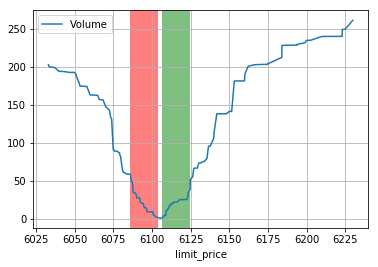

In [152]:
res = show_LOB(df_2)
res.drop(['status', 'order_type'], axis = 1, inplace = True)
res.sort_values(by = ['limit_price'], ascending = True, inplace = True)
fig = res.astype(float).plot(x = 'limit_price', y = 'Volume', )
fig.grid('on')
fig.axvspan(xmin=6104, xmax =6086,facecolor='r', alpha=0.5)
fig.axvspan(xmin=6106.8, xmax =6124.6,facecolor='g', alpha=0.5)
fig = fig.get_figure()
#fig.savefig('C:/Users/janpa/Desktop/Uni/Bachelorarbeit/gathered_stats/VWAP_Beispiel.png')

,orderbook_id,order_id,limit_price,original_amount,status,order_type
0,7,1,6104.0000000000,1.3730000000,PNE,B
1,7,2,6101.0000000000,3.5770000000,PNE,B
2,7,3,6100.9000000000,0.9800000000,PNE,B
3,7,4,6100.6000000000,3.2770000000,PNE,B
4,7,5,6099.9000000000,0.1000000000,PNE,B
5,7,6,6097.4000000000,0.0160000000,PNE,B
6,7,7,6096.8000000000,0.1000000000,PNE,B
7,7,8,6096.7000000000,3.1760000000,PNE,B
8,7,9,6096.2000000000,1.9900000000,PNE,B
9,7,10,6095.1000000000,0.0250000000,PNE,B


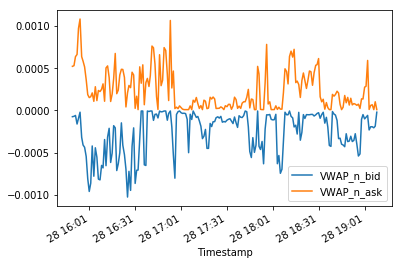

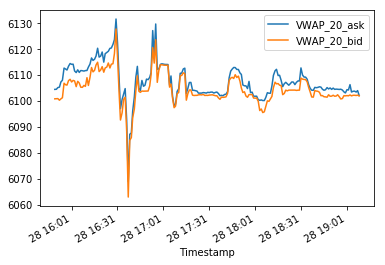

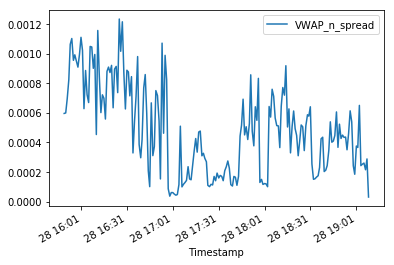

In [26]:
df = df_2
df = df.astype(float)[0:200]

#df.reset_index().plot(x = 'Timestamp', y = ['Max_bid', 'Min_ask'])
#df.reset_index().plot(x = 'Timestamp', y = ['VWAP_20_ask','Max_bid', 'VWAP_20_bid','Min_ask', 'Mid'])
df.reset_index().plot(x = 'Timestamp', y = ['VWAP_n_bid', 'VWAP_n_ask'])

#df.reset_index().plot(x = 'Timestamp', y = 'best_limit_ask_price')
#df.reset_index().plot(x = 'Timestamp', y = ['best_limit_bid_volume', 'best_limit_ask_volume'])
#df.reset_index().plot(x = 'Timestamp', y = ['number_bids', 'number_asks'])
df.reset_index().plot(x = 'Timestamp', y = ['VWAP_20_ask', 'VWAP_20_bid'])
df.reset_index().plot(x = 'Timestamp', y = 'VWAP_n_spread')


plt.show();

In [77]:
Results_restricted_most_recent

,Max_bid,Max_bid_volume,Min_ask,Min_ask_volume,VWAP_20_ask,VWAP_20_bid,ask_total_volume,av_ask_volume_price_ratio,av_bid_volume_price_ratio,bid_total_volume,mean_ask_price,mean_ask_volume,mean_bid_price,mean_bid_volume,number_asks,number_bids,Mid,spread,VWAP_n_bid,VWAP_n_ask
Timestamp,,,,,,,,,,,,,,,,,,,,
2018-06-28 15:50:01+02:00,6101.2000000000,1.2446623900,6101.3000000000,3.7354941700,6104.65797562475000000000,6095.85390871050000000000,774.7515288200,1.563782e+06,23811.281680,512289.5172806100,14433.6928,3.099006,1646.546893,2049.158069,250,250,6101.2500000000,0.00001639008399918049580004097521,-0.0008844238950215119852489244007,0.0005585700675681212866215939357
2018-06-28 15:51:02+02:00,6101.2000000000,1.1167411200,6101.3000000000,3.8300533400,6104.70324378140000000000,6097.88066283740000000000,536.4022844200,1.447237e+06,16994.640769,506226.5025964600,13766.9628,2.145609,2137.885118,2024.906010,250,250,6101.2500000000,0.00001639008399918049580004097521,-0.0005522371911657447244417127638,0.0005659895564679368981766031551
2018-06-28 15:52:01+02:00,6101.2000000000,3.6659273000,6101.3000000000,1.9869157600,6105.36525884995000000000,6098.96771806170000000000,586.2313031800,1.312022e+06,34023.218284,506292.0183860800,13111.4388,2.344925,2500.481879,2025.168074,250,250,6101.2500000000,0.00001639008399918049580004097521,-0.0003740679267854947756607252612,0.0006744943822905142388854742881
2018-06-28 15:53:03+02:00,6101.2000000000,6.4009844500,6101.3000000000,2.2727876900,6105.51670073360000000000,6100.24243188245000000000,744.5750613200,1.176221e+06,49236.448051,504197.8855691800,12652.4448,2.978300,3120.490391,2016.791542,250,250,6101.2500000000,0.00001639008399918049580004097521,-0.0001651412608154066789592296661,0.0006993158342306904322884654784
2018-06-28 15:53:59+02:00,6101.3000000000,6.5285642500,6101.4000000000,1.9684185300,6107.30049568800000000000,6100.77278678655000000000,450.2053843900,1.094097e+06,45443.243391,496877.4644004400,11995.3184,1.800822,3615.918184,1987.509858,250,250,6101.3500000000,0.00001638981536872987125800027863,-0.00009460417996836765633835134847,0.0009752752567874322895752579347
2018-06-28 15:55:00+02:00,6101.3000000000,13.0951980500,6101.4000000000,1.9284185300,6108.00685553185000000000,6101.21455737030000000000,568.2430863600,9.669900e+05,52049.535878,496693.1088723300,11480.3268,2.272972,3736.892960,1986.772435,250,250,6101.3500000000,0.00001638981536872987125800027863,-0.00002219879693838248912126004901,0.001091046331033295909921574733
2018-06-28 15:56:04+02:00,6108.7000000000,6.5473700000,6108.8000000000,1.1865666100,6112.63315062470000000000,6106.79609718760000000000,844.6346604300,8.998800e+05,64351.591562,452355.8429647700,10436.7504,3.378539,4826.900220,1809.423372,250,250,6108.7500000000,0.00001636996112134233681195007162,-0.0003198531307386944956005729486,0.0006356702475465520769388172703
2018-06-28 15:56:58+02:00,6108.7000000000,4.1675220300,6108.8000000000,3.3366560300,6112.30813636665000000000,6106.24396267095000000000,877.2492805300,7.279159e+05,88307.179857,381099.3272882100,9648.0908,3.508997,5334.266405,1524.397309,250,250,6108.7500000000,0.00001636996112134233681195007162,-0.0004102373364518109269490484960,0.0005824655398649478207489257213
2018-06-28 15:57:59+02:00,6108.7000000000,3.3632411900,6108.8000000000,3.2446100200,6111.88831679045000000000,6106.07437953055000000000,953.3617918900,5.508270e+05,82603.895053,346043.8008783000,8917.5232,3.813447,5523.574001,1384.175204,250,250,6108.7500000000,0.00001636996112134233681195007162,-0.0004379980306036423163494986699,0.0005137412384612236545938203397


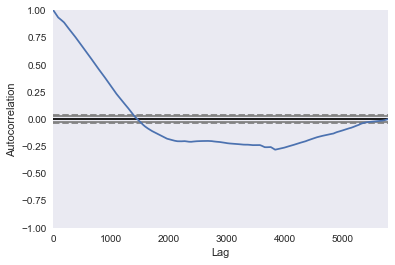

In [32]:
from pandas.plotting import autocorrelation_plot
df = Results_restricted_deviation.astype(np.float)
atp_1 = autocorrelation_plot(df['VWAP_20_ask'])
#atp_2 = autocorrelation_plot(df['Mid'])
#atp_3 = autocorrelation_plot(df['spread'])
#atp_1 = autocorrelation_plot(df['VWAP_n_bid'])
plt.show()


Feature Engeneering Möglichkeiten: 
    beschränke orderbooks nach:
        n erste bid und asks
        n % abweichung vom Mittelwert
        n einheiten volumen 
    betrachte 90% quantil
    überprüfe verteilung von mittel und best preis kursschwankungen
    volatility clustering
    short time influences on bid and ask order arrival 
    
    Orderbook price density
    Spread in first n orders
    Marginal Liquidity costs = average VWAP in a set timeframe
    number of new orders, number of fulfilled orders
    average weighted price
    

Betrachte in den Delta orderbooks nur die Neuen orders im verhältniss zur marktveränderung

Zu erledigen:
    Preis in eingeschränkten orderbüchern: letzter eintrag/erster eintrag (bei einschränkung auf volumen, einträge, ...)
    Volumen in eingeschränkten orderbüchern vergleichen 
    table of features
    
        